# Import

In [2]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models.segmentation as segmentation

import segmentation_models_pytorch as smp
import torchvision.models as models
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.transforms as transforms
from albumentations.core.composition import Compose

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)



cuda


# Fuctions

## RLE decoding/encoding

In [3]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Model save/load

In [5]:
save_dir = "./model_pth/PSP_densenet161/"  # 모델 저장 디렉토리 설정
model_name = "PSP_densenet161_trained_epoch{}.pth"  # 모델 파일 이름 패턴 설정

# 훈련된 모델을 저장하는 함수
def save_model(model, epoch):
    save_path = save_dir + model_name.format(epoch)
    torch.save(model.state_dict(), save_path)
    print(f"Epoch {epoch} 모델 저장이 완료되었습니다.")

# 모델 불러오는 함수
def load_model(model, load_path):
    state_dict = torch.load(load_path)
    # 이전에 저장된 모델과 현재 모델 간 레이어 일치 여부 확인
    model_dict = model.state_dict()
    new_state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
    model_dict.update(new_state_dict)
    model.load_state_dict(model_dict)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print("모델 불러오기가 완료되었습니다.")

## Custom Dataset

In [6]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False): # transform 전처리하거나 다른 형태로 변환하는데 사용, infer 데이터를 추론 모드로 설정할지 여부
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1] # 해당 인덱스에 위치한 데이터프레임의 두 번째 열(column)에 있는 이미지 경로를 가져옴
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2] # 데이터프레임의 idx 행에서 세 번째 열(column)에 있는 마스크 정보를 가져옴
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1])) # 원래의 마스크 이미지로 변환

        if self.transform:
            augmented = self.transform(image=image, mask=mask) # 이미지와 마스크를 변환
            image = augmented['image'] # 변환된 이미지를 딕셔너리에서 가져와 image 변수에 할당
            mask = augmented['mask'] # 변환된 이미지를 딕셔너리에서 가져와 mask 변수에 할당

        return image, mask

## Loss Function

focal Dice loss 클래스 정의

In [6]:
    
class FocalDiceLoss(nn.Module):
    def __init__(self, gamma=2, smooth=1e-6):
        super(FocalDiceLoss, self).__init__()
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Focal Loss 계산
        inputs_prob = torch.sigmoid(inputs)
        focal_loss = -targets * (1 - inputs_prob) ** self.gamma * torch.log(inputs_prob + self.smooth) \
                     - (1 - targets) * inputs_prob ** self.gamma * torch.log(1 - inputs_prob + self.smooth)
        focal_loss = focal_loss.mean()

        # Dice Loss 계산
        dice_target = targets
        dice_output = inputs_prob
        intersection = (dice_output * dice_target).sum()
        union = dice_output.sum() + dice_target.sum()
        dice_loss = 1 - (2.0 * intersection + self.smooth) / (union + self.smooth)

        # Focal Loss와 Dice Loss를 더해서 총 손실을 계산
        total_loss = focal_loss + dice_loss

        return total_loss
    

ce + lovasz 손실함수 클래스 정의

In [7]:
import torch.nn.functional as F
# 손실 함수 정의
class CombinedLoss(nn.Module):
    def __init__(self, ce_weight, lovasz_weight):
        super(CombinedLoss, self).__init__()
        self.ce_weight = ce_weight
        self.lovasz_weight = lovasz_weight

    def forward(self, y_pred, y_true):
        # 크로스 엔트로피(Cross-Entropy) 손실 계산
        ce_loss = F.binary_cross_entropy_with_logits(y_pred, y_true)

        # Lovasz 손실 계산
        lovasz_loss_value = lovasz_loss(y_pred, y_true)

        # 크로스 엔트로피와 Lovasz 손실을 합친 최종 손실 계산
        loss = self.ce_weight * ce_loss + self.lovasz_weight * lovasz_loss_value

        return loss

# Lovasz 손실 구현
def lovasz_loss(y_pred, y_true):
    # y_pred: 모델의 예측값 (크기: 배치 크기 x 채널 x 높이 x 너비)
    # y_true: 실제 레이블 (크기: 배치 크기 x 채널 x 높이 x 너비)

    # 이후에 사용할 변수 설정
    batch_size, _, height, width = y_pred.size()
    y_pred = y_pred.view(batch_size, -1)
    y_true = y_true.view(batch_size, -1)

    # 이진 분류 문제라고 가정, 임계값은 0.5로 설정
    y_pred = (y_pred > 0.5).float()

    # 정렬된 인덱스를 사용하여 예측값을 정렬
    _, indices = torch.sort(y_pred, dim=1, descending=True)

    # Lovasz 손실 계산
    loss = 0.0
    for i in range(batch_size):
        target = y_true[i, indices[i]]
        intersection = target.sum()
        union = target.numel()
        loss += (1.0 - (2.0 * intersection + 1.0) / (union + 1.0))

    return loss / batch_size

# pretrained model define

In [9]:

# psp 모델 정의 with densenet161 backbone
model1 = smp.PSPNet(encoder_name="densenet161",  # 필수 파라미터: 사용할 인코더 백본의 이름
    in_channels=3,    # 필수 파라미터: 입력 이미지의 채널 수 (일반적으로 3(RGB) 또는 1(Grayscale))
    classes=1,        # 필수 파라미터: 세그멘테이션 클래스의 수 (예: 물체 탐지의 경우 물체 클래스 수)
    encoder_weights="imagenet"  # 선택적 파라미터: 사용할 사전 훈련된 인코더 가중치의 경로 또는 'imagenet'으로 설정하여 ImageNet 가중치 사용
)
# 모델을 장치(GPU)로 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 손실 함수 설정 (예시)
#criterion = torch.nn.BCEWithLogitsLoss()

# 옵티마이저 설정 (예시)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)


데이터 증강 확인 코드

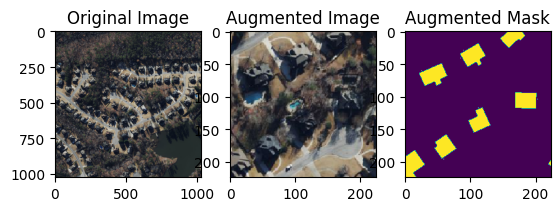

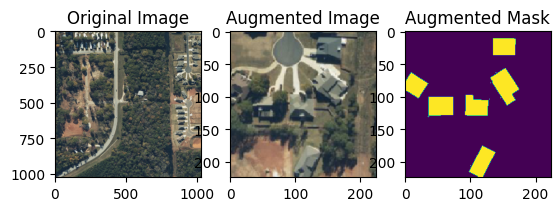

KeyboardInterrupt: 

In [10]:

for epoch in range(10): # 에폭
    epoch+=1
    model.train() # 학습 모드 설정
    epoch_loss = 0
    correct_pixels = 0
    total_pixels = 0

    #데이터 증강을 위한 transform 파이프라인 정의
    transform = A.Compose(
        [
            A.CropNonEmptyMaskIfExists(height=224, width=224),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(limit=30,p=0.3),
            A.ColorJitter(p=0.2),
            A.ToGray(p=0.2),
            # 고정값

            # A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 이미지 픽셀값 정규화
             ToTensorV2()  # 이미지를 텐서로 변환
        ]
    )
    dataset = SatelliteDataset(csv_file='./train.csv') # dataset 불러오기

    aug_dataset = SatelliteDataset(csv_file='./train.csv', transform=transform) # dataset 불러오기

    image,mask=dataset.__getitem__(epoch)
    aug_image,aug_mask=aug_dataset.__getitem__(epoch)
    #print(type(image),type(aug_image))
    #print(type(image.permute(1,2,0).numpy()))
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.subplot(1, 3, 2)
    plt.imshow(aug_image.permute(1,2,0).numpy())
    plt.title('Augmented Image')
    plt.subplot(1, 3, 3)
    plt.imshow(aug_mask.permute(0,1).numpy())
    plt.title('Augmented Mask')
    plt.show()
    


# Model Train

모델 불러와 이어서 훈련시킬때만 주석 제거한 후 사용

In [ ]:
# load_path = "./model_pth/dense161_unet_aug/dense161_unet_trained_epoch22.pth"  # 이전에 저장된 모델 파일 경로
# load_model(model, load_path)

모델 훈련

In [11]:
#그래프 생성 리스트 초기화
train_losses = []
val_losses = []
val_accuracies = []  # 정확도를 저장할 리스트 추가

In [ ]:


for epoch in range(100): # 에폭
    epoch+=1
    model.train() # 학습 모드 설정
    epoch_loss = 0
    correct_pixels = 0
    total_pixels = 0
    
    # 데이터 증강을 위한 transform 파이프라인 정의
    #데이터 증강을 위한 transform 파이프라인 정의
    transform1 = A.Compose(
        [
            A.RandomResizedCrop(224, 224,scale=(0.5, 0.21875),ratio=(1, 1)),  # 랜덤하게 자르기
            A.RandomRotate90(),  # 90도 회전 (랜덤하게)
            A.HorizontalFlip(p=0.5),  # 수평 뒤집기 확률 50%
            A.VerticalFlip(p=0.5),  # 수직 뒤집기 확률 50%
            A.CLAHE(p=0.2),  # CLAHE를 통한 대비 개선
            A.Resize(224, 224),  # 이미지 크기 조정
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()  # 이미지를 텐서로 변환
        ]
    )

    dataset = SatelliteDataset(csv_file='./train.csv', transform=transform1) # dataset 불러오기
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    # Validation 데이터셋과 DataLoader 정의
        # 데이터 증강을 위한 transform 파이프라인 정의
    transform2 = A.Compose(
        [
            A.RandomRotate90(),  # 90도 회전 (랜덤하게)
            A.HorizontalFlip(p=0.5),  # 수평 뒤집기 확률 50%
            A.VerticalFlip(p=0.5),  # 수직 뒤집기 확률 50%
            A.CLAHE(p=0.2),  # CLAHE를 통한 대비 개선

            A.Resize(224, 224),  # 이미지 크기 조정
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()  # 이미지를 텐서로 변환
        ]
    )
    val_dataset = SatelliteDataset(csv_file='./validation.csv', transform=transform2) # 검증 데이터셋을 로드합니다.
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # shuffle=False로 설정하여 검증 데이터셋에서 셔플링을 하지 않도록 합니다.

    for images, masks in tqdm(dataloader):
        # GPU 디바이스로 데이터 이동
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad() # 옵티마이저에 누적된 변화도(gradient)를 초기화
        outputs = model(images) # 입력 이미지를 모델에 전달하여 모델의 출력을 계산
                # 손실 함수 계산
        criterion =FocalDiceLoss()

        loss = criterion(outputs, masks.unsqueeze(1)) # 모델의 출력과 정답 마스크 사이의 손실을 계산
        
        loss.backward() # 역전파를 통해 모델의 파라미터에 대한 손실 함수의 기울기(gradient)를 계산
        optimizer.step() # 옵티마이저를 사용하여 모델의 파라미터를 업데이트

        epoch_loss += loss.item() # 학습 과정에서 전체 에포크의 손실을 계산하기 위해 사용

        # 정확도 계산
        predicted_masks = outputs > 0.5 # 이진 분류 문제라고 가정, 임계값은 0.5로 설정
        correct_pixels += (predicted_masks == masks.byte().unsqueeze(1)).sum().item()
        total_pixels += masks.numel()
    
    model.eval()  # 평가 모드 설정

    val_loss = 0
    val_correct_pixels = 0
    val_total_pixels = 0

    with torch.no_grad():  # 검증 단계에서는 그래디언트 계산을 하지 않습니다.
        for val_images, val_masks in tqdm(val_dataloader):
            # GPU 디바이스로 데이터 이동
            val_images = val_images.float().to(device)
            val_masks = val_masks.float().to(device)
            # 입력 이미지를 모델에 전달하여 모델의 출력을 계산
            val_outputs = model(val_images)
            # 손실 함수 계산
            criterion =FocalDiceLoss()
            # 모델의 출력과 정답 마스크 사이의 손실을 계산
            val_loss = criterion(val_outputs, val_masks.unsqueeze(1))

            #검증 데이터셋에 대한 손실 함수 값들을 누적하여 저장
            val_loss += val_loss.item()
            #모델의 출력이 0.5보다 크면 해당 픽셀이 1로 예측된 것으로 간주되고, 그렇지 않은 경우에는 0으로 예측된 것으로 간주하여 예측한 마스크를 저장
            val_predicted_masks = val_outputs > 0.5
            #올바르게 예측한 픽셀의 수를 누적
            val_correct_pixels += (val_predicted_masks == val_masks.byte().unsqueeze(1)).sum().item()
            #검증 데이터셋의 모든 이미지에서 총 픽셀 수를 계산하여 val_total_pixels에 누적
            val_total_pixels += val_masks.numel()

    val_loss /= len(val_dataloader)
    val_accuracy = val_correct_pixels / val_total_pixels
    val_accuracies.append(val_accuracy)  # 정확도를 리스트에 저장
    # 각 에폭이 끝날 때마다 모델 저장
    save_path = save_dir + model_name.format(epoch)
    torch.save(model.state_dict(), save_path)
    print(f"Epoch {epoch} 모델 저장이 완료되었습니다.")

    epoch_loss /= len(dataloader)
    accuracy = correct_pixels / total_pixels

    print(f'Epoch {epoch}, Loss: {epoch_loss}, Accuracy: {accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}')
    train_losses.append(epoch_loss)
    val_losses.append(val_loss)

    # Plot the losses after each epoch
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), [loss.item() for loss in val_losses], label='Validation Loss')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')  # 정확도를 그래프에 추가

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Prediction 

test or validation datasets 이미지 변환

In [ ]:
transform = A.Compose(
    [
        A.Resize(224, 224), # 이미지 크기 조정
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # 이미지 픽셀값 정규화
        ToTensorV2() # 이미지를 텐서로 변환
    ]
)

# Data Loader (test or val)

test or validation datasets 둘 중 하나 주석 제거 후 load 

 Test Data Loader

In [15]:

# test_dataset = SatelliteDataset(csv_file='./test.csv', transform=transform, infer=True)
# test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
# print(len(test_dataset))
# print(len(test_dataloader))

60640
3790


Validation Data Loader 자체 검증용

In [20]:
test_dataset = SatelliteDataset(csv_file='./validation.csv', transform=transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
print(len(test_dataset))
print(len(test_dataloader))

100
7


# Load Model

최종 모델 불러와서 추론하기

In [19]:

#불러올 모델의 정의
model = smp.PSPNet(encoder_name="densenet161",  # 필수 파라미터: 사용할 인코더 백본의 이름
    in_channels=3,    # 필수 파라미터: 입력 이미지의 채널 수 (일반적으로 3(RGB) 또는 1(Grayscale))
    classes=1,        # 필수 파라미터: 세그멘테이션 클래스의 수 (예: 물체 탐지의 경우 물체 클래스 수)
    encoder_weights="imagenet"  # 선택적 파라미터: 사용할 사전 훈련된 인코더 가중치의 경로 또는 'imagenet'으로 설정하여 ImageNet 가중치 사용
)
# 저장된 모델의 파라미터 불러오기 (strict=False 옵션 사용)
state_dict = torch.load('./ensemble/three/psp_dense_base_trained_epoch55.pth', map_location=torch.device('cpu'))

# 모델의 파라미터 로드
model.load_state_dict(state_dict, strict=False)

# GPU 사용이 가능한 경우에는 GPU로 데이터 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

PSPNet(
  (encoder): DenseNetEncoder(
    (features): Sequential(
      (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(144, eps=1e-05, momen

# Inference

 (test_dataset 변수에 validation 데이터를 불러오면 score 산출 가능)

In [22]:
# 결과를 저장할 리스트 초기화
result = []

with torch.no_grad(): # 역전파 비활성화, 파라미터 업데이트 금지
    # print(len(test_dataloader))
    for images in tqdm(test_dataloader): # 데이터 로드
        images = images.float().to(device) 

        outputs = model(images)# 테스트 이미지 전달하여 예측 결과 얻음
        masks = torch.sigmoid(outputs).cpu().numpy() # outputs는 모델 예측 결과, 확률값으로 변환하기 위해 시그모이드 함수 적용한 후 각 픽셀 값을 0과 1사이의 확률값으로 변환하고, 넘파이 배열로 변환
        masks = np.squeeze(masks, axis=1) # 불필요한 차원 제거
        masks = (masks > 0.3).astype(np.uint8) # 최종 이진화 예측 마스크 얻음
        # print(len(images))
        for i in range(len(images)):
            mask_rle = rle_encode(masks[i]) # RLE로 변환, mask_rle에 인코딩 결과 저장
            if mask_rle == '':
                result.append(-1) # 빌딩 없으면 -1 저장
            else:
                result.append(mask_rle) # 아니면 mask_rle 저장

            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])

            # 이미지를 정규화 해제
            visualized_image = (images[i].cpu().numpy().transpose((1, 2, 0)) * std + mean) * 255# 이미지 시각화하기 위해 넘파이 배열로 가져옴
            visualized_image = np.clip(visualized_image, 0, 255).astype(np.uint8)

            masks_visualized = masks[i] * 255 # 이진화 마스크로 변환

            # plt.subplot(1, 2, 1)
            # plt.imshow(visualized_image)
            # plt.title("Input Image")

            # plt.subplot(1, 2, 2)
            # plt.imshow(masks_visualized, cmap='gray')
            # plt.title("Predicted Mask")

            # plt.show()

100%|██████████| 7/7 [00:01<00:00,  3.94it/s]


In [23]:
print(len(result))

100


# Submission

60000개의 test 데이터 추론 결과 저장

In [24]:
submit = pd.read_csv('./sample_submission.csv')
submit['mask_rle'] = result

In [26]:
submit.to_csv('./test_submit_psp_densenet161.csv', index=False)

자체 검증 데이터 추론 결과 저장

In [24]:
submit = pd.read_csv('./validation_sample.csv')
submit['mask_rle'] = result

In [25]:
submit.to_csv('./validation_submit_psp_densenet161.csv', index=False)

# dice score 평가산식

점수 확인하기 , csv파일 변경후 확인할것

In [26]:
import numpy as np
import pandas as pd
from typing import List, Union
from joblib import Parallel, delayed


def rle_decode(mask_rle: Union[str, int], shape=(224, 224)) -> np.array:
    '''
    mask_rle: run-length as string formatted (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    if mask_rle == -1:
        return np.zeros(shape)
    
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def dice_score(prediction: np.array, ground_truth: np.array, smooth=1e-7) -> float:
    '''
    Calculate Dice Score between two binary masks.
    '''
    intersection = np.sum(prediction * ground_truth)
    return (2.0 * intersection + smooth) / (np.sum(prediction) + np.sum(ground_truth) + smooth)


def calculate_dice_scores(ground_truth_df, prediction_df, img_shape=(224, 224)) -> List[float]:
    '''
    Calculate Dice scores for a dataset.
    '''


    # Keep only the rows in the prediction dataframe that have matching img_ids in the ground truth dataframe
    prediction_df = prediction_df[prediction_df.iloc[:, 0].isin(ground_truth_df.iloc[:, 0])]
    prediction_df.index = range(prediction_df.shape[0])


    # Extract the mask_rle columns
    pred_mask_rle = prediction_df.iloc[:, 1]
    gt_mask_rle = ground_truth_df.iloc[:, 2]


    def calculate_dice(pred_rle, gt_rle):
        pred_mask = rle_decode(pred_rle, img_shape)
        gt_mask = rle_decode(gt_rle, img_shape)


        if np.sum(gt_mask) > 0 or np.sum(pred_mask) > 0:
            return dice_score(pred_mask, gt_mask)
        else:
            return None  # No valid masks found, return None


    dice_scores = Parallel(n_jobs=-1)(
        delayed(calculate_dice)(pred_rle, gt_rle) for pred_rle, gt_rle in zip(pred_mask_rle, gt_mask_rle)
    )


    dice_scores = [score for score in dice_scores if score is not None]  # Exclude None values


    return np.mean(dice_scores)
# csv 경로 수정
answer_csv = "./validation.csv"
predict_csv = "./validation_submit_psp_densenet161.csv"

train_df = pd.read_csv(answer_csv)
predict_df = pd.read_csv(predict_csv)

dice_score = calculate_dice_scores(train_df, predict_df)
print(dice_score)

0.7444062865136029


# Model ensemble

model load

아래 코드는 ensemble model이 3개일때 예시임

In [27]:
model1 = smp.PSPNet(encoder_name="densenet161",  # 필수 파라미터: 사용할 인코더 백본의 이름
    in_channels=3,    # 필수 파라미터: 입력 이미지의 채널 수 (일반적으로 3(RGB) 또는 1(Grayscale))
    classes=1,        # 필수 파라미터: 세그멘테이션 클래스의 수 (예: 물체 탐지의 경우 물체 클래스 수)
    encoder_weights="imagenet"  # 선택적 파라미터: 사용할 사전 훈련된 인코더 가중치의 경로 또는 'imagenet'으로 설정하여 ImageNet 가중치 사용
)
# DeepLabV3+ 모델 정의
model2 = smp.DeepLabV3Plus(
    encoder_name="timm-mobilenetv3_large_100",   # 백본으로 ResNet-50 사용
    encoder_weights="imagenet", # ImageNet 가중치로 초기화
    in_channels=3,             # 입력 이미지 채널 수 (RGB 이미지인 경우 3)
    classes=1                  # 출력 클래스 수 (이진 분류인 경우 1)
)

model3 = smp.Unet(encoder_name="resnet50",  # 필수 파라미터: 사용할 인코더 백본의 이름
    in_channels=3,    # 필수 파라미터: 입력 이미지의 채널 수 (일반적으로 3(RGB) 또는 1(Grayscale))
    classes=1,        # 필수 파라미터: 세그멘테이션 클래스의 수 (예: 물체 탐지의 경우 물체 클래스 수)
    encoder_weights="imagenet"  # 선택적 파라미터: 사용할 사전 훈련된 인코더 가중치의 경로 또는 'imagenet'으로 설정하여 ImageNet 가중치 사용
)

# 저장된 모델의 파라미터 불러오기 (strict=False 옵션 사용)
state_dict_1 = torch.load('./ensemble/three/psp_dense_base_trained_epoch55.pth', map_location=torch.device('cpu'))
state_dict_2 = torch.load('./ensemble/three/v3plus_mobilenet_epoch42.pth', map_location=torch.device('cpu'))
state_dict_3 = torch.load('./ensemble/three/resnet_50_unet_new_aug_noempty_trained_epoch21.pth', map_location=torch.device('cpu'))

# 모델의 파라미터 로드
model1.load_state_dict(state_dict_1, strict=False)
model2.load_state_dict(state_dict_2, strict=False)
model3.load_state_dict(state_dict_3, strict=False)

# GPU 사용이 가능한 경우에는 GPU로 데이터 이동
device1 = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device2 = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device3 = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# b5=b5Model.to(b5Device)
# mob=mobModel.to(mobDevice)
# print(b5+mob)
model1.to(device1)
model2.to(device2)
model3.to(device3)
# print(mobModel.to(mobDevice))
# print(b5Model.to(b5Device))

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

# Inference 

(Voting 앙상블,Averaging 앙상블) , test_data변수에 test데이터 와 validation 데이터 중 선택하여 로드할것 코드(validation data load ,test data load)는 위에 있음

In [ ]:
# 결과를 저장할 리스트 초기화
result1 = []
result2=[]
result3=[]
all_result=[]
vote_result=[]


with torch.no_grad(): # 역전파 비활성화, 파라미터 업데이트 금지
    # print(len(test_dataloader))
    for images in tqdm(test_dataloader): # 데이터 로드
        images = images.float().to(device) 

        outputs1 = model1(images) # 테스트 이미지 전달하여 예측 결과 얻음
        outputs2 = model2(images) # 테스트 이미지 전달하여 예측 결과 얻음
        outputs3 = model3(images) # 테스트 이미지 전달하여 예측 결과 얻음
        
        #다수결 방식
        ensemble_vote = (outputs1 + outputs2 + outputs3) >=2
        

        masks1 = torch.sigmoid(outputs1).cpu().numpy() # outputs는 모델 예측 결과, 확률값으로 변환하기 위해 시그모이드 함수 적용한 후 각 픽셀 값을 0과 1사이의 확률값으로 변환하고, 넘파이 배열로 변환
        masks2 = torch.sigmoid(outputs2).cpu().numpy() # outputs는 모델 예측 결과, 확률값으로 변환하기 위해 시그모이드 함수 적용한 후 각 픽셀 값을 0과 1사이의 확률값으로 변환하고, 넘파이 배열로 변환
        masks3 = torch.sigmoid(outputs3).cpu().numpy() # outputs는 모델 예측 결과, 확률값으로 변환하기 위해 시그모이드 함수 적용한 후 각 픽셀 값을 0과 1사이의 확률값으로 변환하고, 넘파이 배열로 변환
        
        # allMasks= masks1*0.7+masks2*0.15+masks3*0.15
        allMasks= masks1*0.7+masks2*0.15+masks3*0.15
        
        masks1 = np.squeeze(masks1, axis=1) # 불필요한 차원 제거
        masks1 = (masks1 > 0.35).astype(np.uint8) # 최종 이진화 예측 마스크 얻음
        
        masks2 = np.squeeze(masks2, axis=1) # 불필요한 차원 제거
        masks2 = (masks2 > 0.35).astype(np.uint8) # 최종 이진화 예측 마스크 얻음

        masks3 = np.squeeze(masks3, axis=1) # 불필요한 차원 제거
        masks3 = (masks3 > 0.35).astype(np.uint8) # 최종 이진화 예측 마스크 얻음

        # print(len(images))
        allMasks = np.squeeze(allMasks, axis=1) # 불필요한 차원 제거
        allMasks = (allMasks > 0.30).astype(np.uint8) # 최종 이진화 예측 마스크 얻음


        for i in range(len(images)):
            mask_rle1 = rle_encode(masks1[i]) # RLE로 변환, mask_rle에 인코딩 결과 저장

            if mask_rle1 == '':
                result1.append(-1) # 빌딩 없으면 -1 저장
            else:
                result1.append(mask_rle1) # 아니면 mask_rle 저장

        for i in range(len(images)):
            mask_rle2 = rle_encode(masks2[i]) # RLE로 변환, mask_rle에 인코딩 결과 저장

            if mask_rle2 == '':
                result2.append(-1) # 빌딩 없으면 -1 저장
            else:
                result2.append(mask_rle2) # 아니면 mask_rle 저장

        for i in range(len(images)):
            mask_rle3 = rle_encode(masks3[i]) # RLE로 변환, mask_rle에 인코딩 결과 저장

            if mask_rle3 == '':
                result3.append(-1) # 빌딩 없으면 -1 저장
            else:
                result3.append(mask_rle3) # 아니면 mask_rle 저장

        for i in range(len(images)):
            all_mask_rle = rle_encode(allMasks[i]) # RLE로 변환, mask_rle에 인코딩 결과 저장

            if all_mask_rle == '':
                all_result.append(-1) # 빌딩 없으면 -1 저장
            else:
                all_result.append(all_mask_rle) # 아니면 mask_rle 저장
        

        for i in range(len(images)):
            ensemble_vote_cpu=ensemble_vote[i].cpu()
            vote_mask_rle = rle_encode(ensemble_vote_cpu) # RLE로 변환, mask_rle에 인코딩 결과 저장

            if vote_mask_rle == '':
                vote_result.append(-1) # 빌딩 없으면 -1 저장
            else:
                vote_result.append(vote_mask_rle) # 아니면 mask_rle 저장

           
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])

            # 이미지를 정규화 해제
            visualized_image = (images[i].cpu().numpy().transpose((1, 2, 0)) * std + mean) * 255
            visualized_image = np.clip(visualized_image, 0, 255).astype(np.uint8)

            #visualized_image = images[i].cpu().numpy().transpose((1, 2, 0)) # 이미지 시각화하기 위해 넘파이 배열로 가져옴
            #print(visualized_image)
            masks_visualized1 = masks1[i] * 255 # 이진화 마스크로 변환
            masks_visualized2 = masks2[i] * 255 # 이진화 마스크로 변환
            masks_visualized3 = masks3[i] * 255 # 이진화 마스크로 변환
            
            all_masks_visualized = allMasks[i] * 255 # 이진화 마스크로 변환
            vote_masks_visualized = ensemble_vote_cpu.numpy().squeeze() * 255 # 이진화 마스크로 변환
            
            plt.figure(figsize=(15, 10))  # 원하는 크기로 조정

            plt.subplot(1, 6, 1)
            plt.imshow(visualized_image)
            plt.title("Input Image")

            plt.subplot(1, 6, 2)
            plt.imshow(masks_visualized1, cmap='gray')
            plt.title("deeplabV3 Mask")

            plt.subplot(1, 6, 3)
            plt.imshow(masks_visualized2, cmap='gray')
            plt.title("PSP Mask")

            plt.subplot(1, 6, 4)
            plt.imshow(masks_visualized3, cmap='gray')
            plt.title("Unet Mask")

            plt.subplot(1, 6, 5)
            plt.imshow(all_masks_visualized, cmap='gray')
            plt.title("all Mask")

            plt.subplot(1, 6, 6)
            plt.imshow(vote_masks_visualized, cmap='gray')
            plt.title("vote Mask")

            plt.show()

# ensemble Submission

test datasets 일때와 validation datasets 를 잘 구분하여 주석 제거 후 사용

In [ ]:
#test데이터 추론일때
submit = pd.read_csv('./sample_submission.csv')
#검증데이터 추론일때
#submit = pd.read_csv('./validation_submission.csv')

평균 앙상블기법

In [ ]:
submit['mask_rle'] = all_result
submit.to_csv('./ensemble/three/all_sample_submission_new-unet.csv', index=False)

voting ensemble 

In [ ]:
submit['mask_rle'] = vote_result
submit.to_csv('./ensemble/three/all_sample_submission_new-unet.csv', index=False)

validation datasets 평가산식 점수는 위의 dice score 참조